### Prepare soiltype input for discretization ###
Prepare soiltype input data for the basin area. This step includes:<br>
1. project full-domain soiltype raster to a common projection system.
2. extract soiltype for the basin area.
3. check basin soiltype.

In [1]:
# import libraries
import os,sys
sys.path.append('../')
import functions.geospatial_analysis as ga
import functions.geospatial_plot as gp
import functions.utils as ut
import rasterio as rio
from rasterio.warp import Resampling

In [2]:
# common paths
control_file    = '../control_Utah.txt'
basin_data_path = ut.read_from_control(control_file, 'basin_data_path')
basin_name      = ut.read_from_control(control_file, 'basin_name')
plot_path       = os.path.join(basin_data_path, 'plots/')
gis_path        = os.path.join(basin_data_path, 'gis')

In [3]:
# define equal area projection system
new_epsg = ut.read_from_control(control_file, 'epsg') 
dest_crs = rio.crs.CRS.from_epsg(new_epsg)

In [4]:
# full-domain data
soiltype_raster       = ut.read_from_control(control_file, 'fulldom_soiltype_raster')
soiltype_resample_raster = ut.set_filename(control_file, 'basin_soil_resample_raster')

# basin data
basin_gru_shp         = ut.set_filename(control_file, 'basin_gru_shp')
basin_flowline_shp    = ut.set_filename(control_file, 'basin_flowlines_shp')
basin_soiltype_raster = ut.set_filename(control_file, 'basin_soiltype_raster')
refraster             = ut.set_filename(control_file, 'refraster')

# derived filenames
basin_gru_prj_shp     = os.path.join(gis_path, os.path.basename(basin_gru_shp).split('.shp')[0]+'_prj.shp') 
soiltype_prj_raster   = os.path.join(gis_path, os.path.basename(soiltype_raster).split('.tif')[0]+'_prj.tif')


#### 1. Reproject full-domain soiltype #### 

In [6]:
# if this is slow, the file can be prepared externally using gdalwarp -t_srs EPSG:<epsg> <input_tif> <output_tif>
if not os.path.exists(soiltype_prj_raster):
    ga.reproject_raster(soiltype_raster, soiltype_prj_raster, dest_crs, Resampling.nearest) 
elif os.path.exists(soiltype_prj_raster):
    with rio.open(soiltype_prj_raster) as raster:       
        if raster.crs != dest_crs: # Get the projection information
            print('Existing projected raster does not match the desired dest_crs')
            ga.reproject_raster(soiltype_raster, soiltype_prj_raster, dest_crs, Resampling.nearest) 
print('reprojected soil raster:', soiltype_prj_raster)

reprojected soil raster: /Users/hongliliu/Documents/tmp/utah/gis/usda_mode_soilclass_vCompressed_NA_250m_ll_prj.tif


In [7]:
# double check the reprojection succeeds.
import rasterio as rio
def get_raster_projection(raster_path):
    # Open the raster file using rasterio
    with rio.open(raster_path) as raster:
        # Get the projection information
        raster_crs = raster.crs
    return raster_crs

print(get_raster_projection(soiltype_raster))    
print(get_raster_projection(soiltype_prj_raster))

EPSG:4326
EPSG:6933


#### 2. Resample soiltype 

In [8]:
ga.resample_raster(soiltype_prj_raster, refraster, soiltype_resample_raster) 
print('resampled landcover: ', soiltype_resample_raster)

resampled landcover:  /Users/hongliliu/Documents/tmp/utah/gis/soiltype_resample.tif


#### 3. Extract basin soiltype ####

In [9]:
ga.crop_raster(soiltype_resample_raster, basin_gru_prj_shp, basin_soiltype_raster) 
print('substted soil raster:', basin_soiltype_raster)

substted soil raster: /Users/hongliliu/Documents/tmp/utah/gis/soiltype.tif


#### 4. Visualize basin soil ####

data_unique: [0. 2. 3. 8.]
data_counts: [330278   2935 255397   6180]


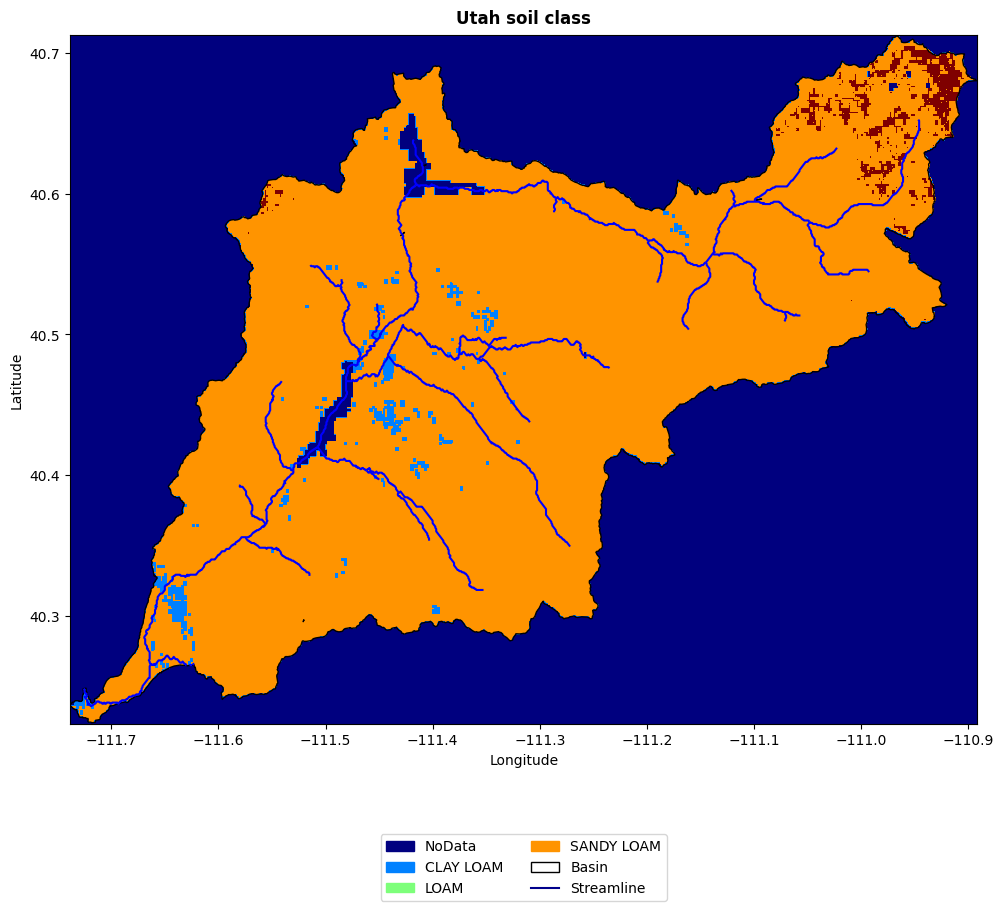

In [10]:
# plot settings
wgs_crs  = 'epsg:4326'
wgs_epsg = 4326
figsize  = (15,15*0.6) # width, height in inches
title    = basin_name.capitalize() + ' soil class'
leg_ncol = 2
leg_loc  = 'upper center'
leg_bbox_to_anchor=(0.5,-0.15)

legend_dict = {0: "NoData",
               1: 'CLAY',
               2: 'CLAY LOAM',
               3: 'LOAM',
               4: 'LOAMY SAND',
               5: 'SAND',
               6: 'SANDY CLAY',
               7: 'SANDY CLAY LOAM',
               8: 'SANDY LOAM',
               9: 'SILT',
               10: 'SILTY CLAY',
               11: 'SILTY CLAY LOAM',
               12: 'SILT LOAM'}   

# plot classified aspect
output_fig_file = os.path.join(plot_path, 'soiltype_and_bound_stream.png')   
cmap_str = 'jet'

gp.plot_raster_and_bound_stream(basin_soiltype_raster, basin_gru_prj_shp, basin_flowline_shp, wgs_epsg, cmap_str, legend_dict,
                                figsize, title, leg_loc, leg_bbox_to_anchor, leg_ncol, output_fig_file)